In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load the smaller dataset stored in GitHub
url = "https://raw.githubusercontent.com/emilyburr7/horse-race-times-ml/main/data/raceform_small.csv"

df = pd.read_csv(url)
df.head()


,date,course,race_id,off,race_name,type,class,pattern,rating_band,age_band,...,trainer,prize,or,rpr,ts,sire,dam,damsire,owner,comment
0,2022-04-02,Saint-Cloud (FR),809089,2:15,Prix du Languedoc (Handicap) (4yo+) (Turf),Flat,NaN,NaN,NaN,4yo+,...,D Smaga,NaN,–,87,41,Whipper (USA),Envoutement (FR),Vettori,Alain Louis Dreyfus,NaN
1,2021-06-03,Longchamp (FR),786801,6:00,Prix du Val de Grace (Claimer) (4yo+) (Moyenne...,Flat,NaN,NaN,NaN,4yo+,...,E Lyon,NaN,–,47,21,Kingsalsa (USA),Ma Bonne Etoile (FR),Medaaly,Roland Monnier,NaN
2,2015-03-21,Tampa Bay Downs (USA),621984,7:40,Maiden Special Weight (3yo) (Turf),Flat,NaN,NaN,NaN,3yo,...,Michele Boyce,2564.1,–,–,–,City Zip (USA),Jelly Roll (USA),Smart Strike,Caroline Mansour Cherrywood Racing Stables Ii,NaN
3,2021-01-29,Chantilly (FR),777313,2:05,Prix de Noisy-Sur-Oise (Handicap) (5yo+) (All-...,Flat,NaN,NaN,NaN,5yo+,...,D Smaga,NaN,–,64,–,Rip Van Winkle (IRE),Victoria College (FR),Rock Of Gibraltar,David Smaga,NaN
4,2022-11-06,Sandown,822748,12:50,Jumps Are Back Conditional Jockeys Handicap Hu...,Hurdle,Class 3,NaN,0-130,3yo+,...,Nigel Twiston-Davies,2835.17,110,115,52,Fame And Glory (GB),Glory Days (GER),Tiger Hill,Charles C Walker,Took keen hold - in rear - slow jump 4th - not...


In [ ]:
df.info()
df.describe(include='all')
df.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         50000 non-null  object 
 1   course       50000 non-null  object 
 2   race_id      50000 non-null  int64  
 3   off          50000 non-null  object 
 4   race_name    50000 non-null  object 
 5   type         50000 non-null  object 
 6   class        28968 non-null  object 
 7   pattern      7034 non-null   object 
 8   rating_band  20781 non-null  object 
 9   age_band     49999 non-null  object 
 10  sex_rest     6480 non-null   object 
 11  dist         50000 non-null  object 
 12  going        50000 non-null  object 
 13  ran          50000 non-null  int64  
 14  num          49821 non-null  float64
 15  pos          50000 non-null  object 
 16  draw         34024 non-null  float64
 17  ovr_btn      50000 non-null  object 
 18  btn          50000 non-null  object 
 19  hors

['date',
 'course',
 'race_id',
 'off',
 'race_name',
 'type',
 'class',
 'pattern',
 'rating_band',
 'age_band',
 'sex_rest',
 'dist',
 'going',
 'ran',
 'num',
 'pos',
 'draw',
 'ovr_btn',
 'btn',
 'horse',
 'age',
 'sex',
 'wgt',
 'hg',
 'time',
 'sp',
 'jockey',
 'trainer',
 'prize',
 'or',
 'rpr',
 'ts',
 'sire',
 'dam',
 'damsire',
 'owner',
 'comment']

In [ ]:
# HELPER FUNCTIONS FOR FEATURE ENGINEERING

import re

def time_to_seconds(t):
    if pd.isna(t):
        return np.nan
    match = re.match(r'(?:(\d+)m)?\s*(\d+(?:\.\d+)?)s', str(t))
    if match:
        minutes = float(match.group(1)) if match.group(1) else 0
        seconds = float(match.group(2))
        return minutes * 60 + seconds
    return np.nan

def parse_fraction(text):
    fractions = {'½': 0.5, '¼': 0.25, '¾': 0.75}
    for f, v in fractions.items():
        text = text.replace(f, f"+{v}")
    return text

def convert_distance(d):
    if pd.isna(d):
        return np.nan
    d = str(d).strip()
    d = parse_fraction(d)
    miles, furlongs = 0, 0
    if 'm' in d:
        parts = d.split('m')
        try:
            miles = eval(parts[0])
        except:
            miles = np.nan
        if 'f' in parts[1]:
            try:
                furlongs = eval(parts[1].replace('f', ''))
            except:
                furlongs = np.nan
    elif 'f' in d:
        try:
            furlongs = eval(d.replace('f', ''))
        except:
            furlongs = np.nan
    return miles * 8 + furlongs

def weight_to_lbs(w):
    if pd.isna(w):
        return np.nan
    if '-' not in str(w):
        return np.nan
    st, lbs = str(w).split('-')
    return int(st) * 14 + int(lbs)


In [ ]:
df['time_seconds'] = df['time'].apply(time_to_seconds)
df['distance_f'] = df['dist'].apply(convert_distance)
df['weight_lbs'] = df['wgt'].apply(weight_to_lbs)


In [ ]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop columns with too many missing values
missing_threshold = 0.6
df = df[df.columns[df.isnull().mean() < missing_threshold]]
df.shape


(50000, 36)

In [ ]:
import re
import numpy as np
import pandas as pd

def time_to_seconds(t):
    if pd.isna(t):
        return np.nan

    t = str(t).strip()

    match_m_s = re.match(r"(\d+)m\s*(\d+(\.\d+)?)s", t)
    if match_m_s:
        minutes = float(match_m_s.group(1))
        seconds = float(match_m_s.group(2))
        return minutes * 60 + seconds

    match_colon = re.match(r"(\d+):(\d+(\.\d+)?)", t)
    if match_colon:
        minutes = float(match_colon.group(1))
        seconds = float(match_colon.group(2))
        return minutes * 60 + seconds

    return np.nan



In [ ]:
df["time_seconds"] = df["time"].apply(time_to_seconds)


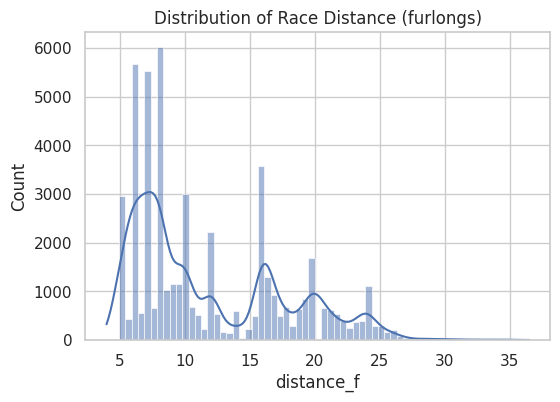

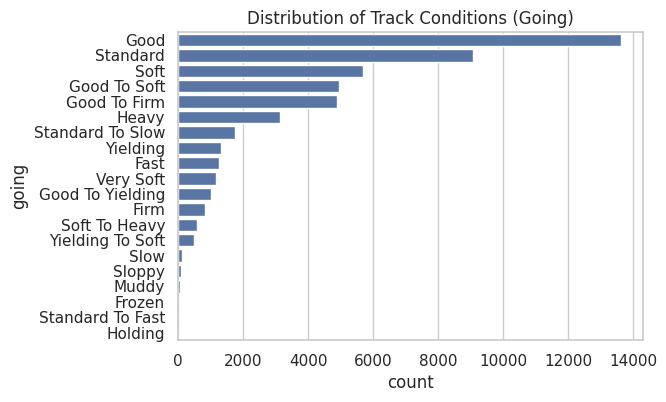

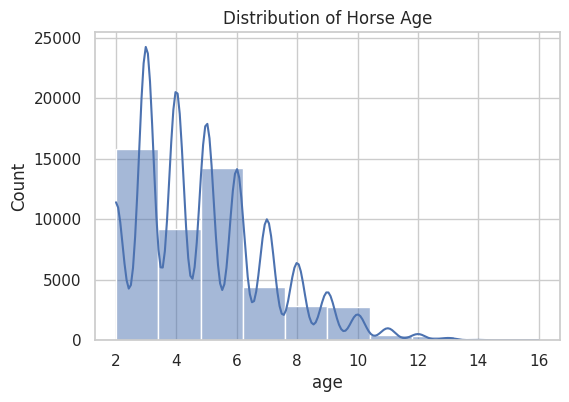

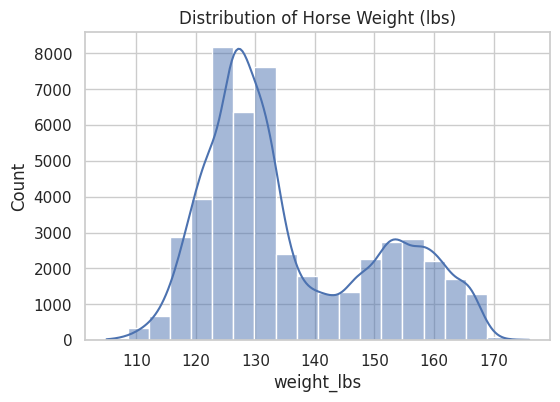

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df["distance_f"], kde=True)
plt.title("Distribution of Race Distance (furlongs)")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(y=df["going"], order=df["going"].value_counts().index)
plt.title("Distribution of Track Conditions (Going)")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["age"], bins=10, kde=True)
plt.title("Distribution of Horse Age")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["weight_lbs"], bins=20, kde=True)
plt.title("Distribution of Horse Weight (lbs)")
plt.show()


In [ ]:
import re
from fractions import Fraction

def parse_fraction(text):
    """Convert unicode fractions like ½, ¼, ¾ to decimals."""
    fractions = {
        '½': 0.5,
        '¼': 0.25,
        '¾': 0.75
    }
    for f, v in fractions.items():
        text = text.replace(f, f"+{v}")   # turns '5½' -> '5+0.5'
    return text

def convert_distance(d):
    if pd.isna(d):
        return np.nan

    d = str(d).strip()

    # Replace unicode fractions with +decimals
    d = parse_fraction(d)

    miles = 0
    furlongs = 0

    # Case 1: Contains miles (e.g., '1m4f' or '1½m')
    if 'm' in d:
        parts = d.split('m')

        # Convert miles part
        try:
            miles = eval(parts[0])
        except:
            miles = np.nan

        # If furlongs also appear
        if 'f' in parts[1]:
            try:
                furlongs = eval(parts[1].replace('f',''))
            except:
                furlongs = np.nan

    # Case 2: Only furlongs (e.g., '5f' or '5½f')
    elif 'f' in d:
        try:
            furlongs = eval(d.replace('f',''))
        except:
            furlongs = np.nan

    # Convert miles → furlongs (1 mile = 8 furlongs)
    return miles*8 + furlongs


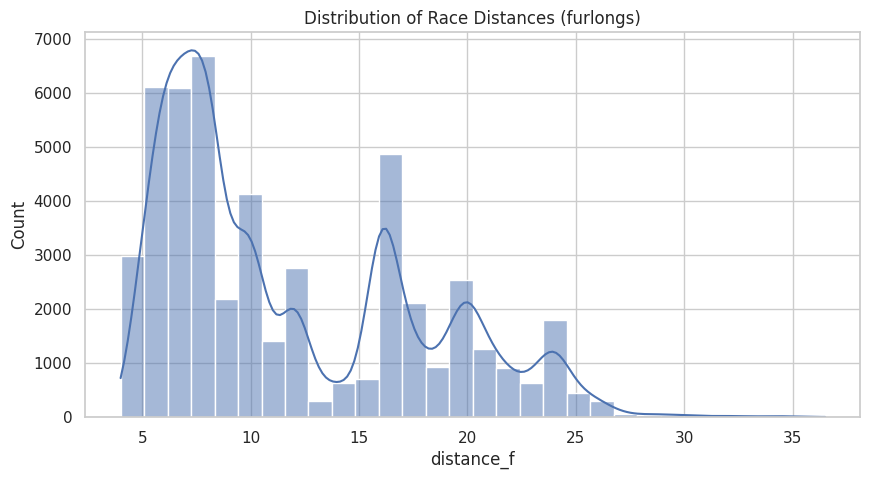

In [ ]:
df['distance_f'] = df['dist'].apply(convert_distance)

plt.figure(figsize=(10,5))
sns.histplot(df['distance_f'], bins=30, kde=True)
plt.title("Distribution of Race Distances (furlongs)")
plt.show()


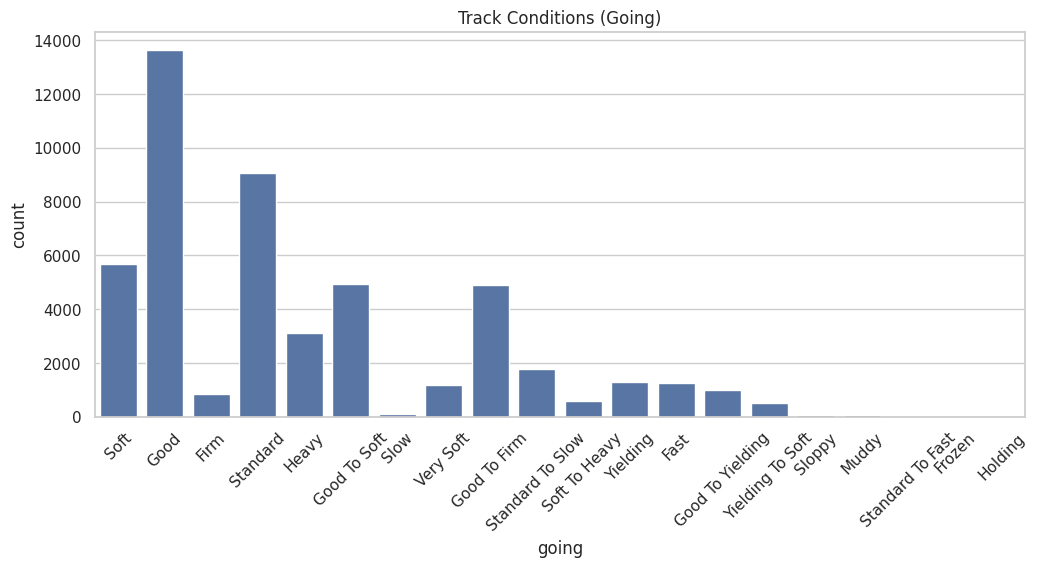

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='going')
plt.title("Track Conditions (Going)")
plt.xticks(rotation=45)
plt.show()


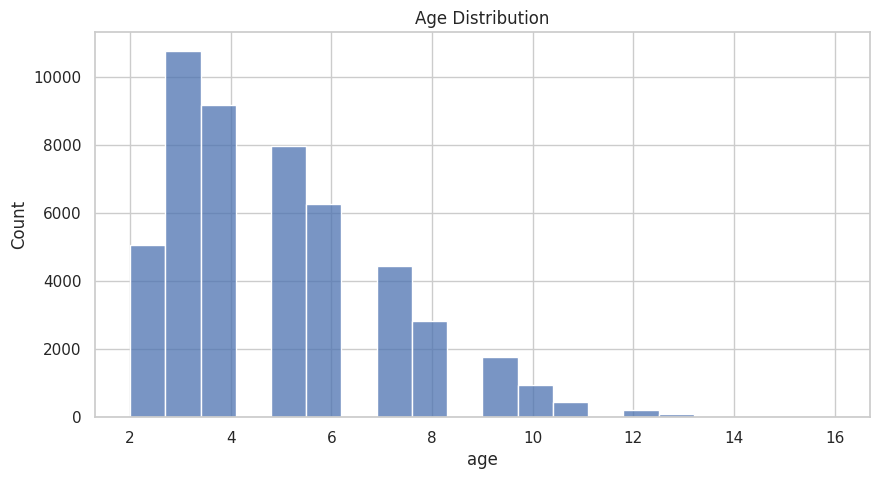

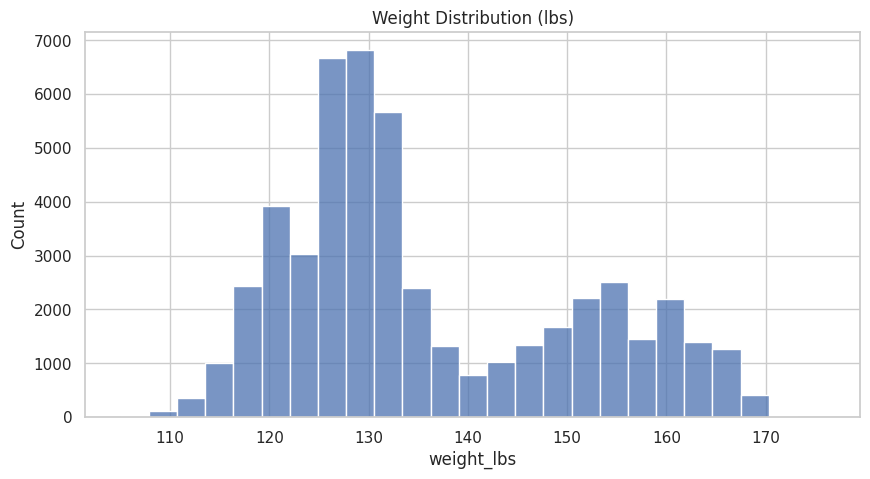

In [ ]:
def weight_to_lbs(w):
    if pd.isna(w):
        return np.nan
    if '-' not in str(w):
        return np.nan
    st, lbs = str(w).split('-')
    return int(st)*14 + int(lbs)

df['weight_lbs'] = df['wgt'].apply(weight_to_lbs)

plt.figure(figsize=(10,5))
sns.histplot(df['age'], bins=20)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['weight_lbs'], bins=25)
plt.title("Weight Distribution (lbs)")
plt.show()
